In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)


In [ ]:
counts.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [ ]:
daily = counts.resample('d').sum()
daily['Total'] = daily['Fremont Bridge Total']
daily = daily[['Total']] # remove other columns
daily.head()

,Total
Date,
2012-10-03,7042.0
2012-10-04,6950.0
2012-10-05,6296.0
2012-10-06,4012.0
2012-10-07,4284.0


We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [ ]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(8.0, 17.0)

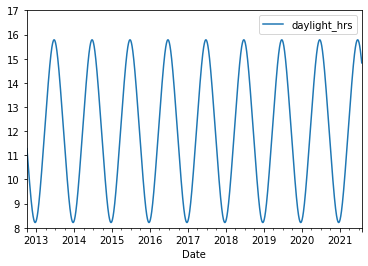

In [ ]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [ ]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [ ]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [ ]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set ``fit_intercept = False``, because the daily flags essentially operate as their own day-specific intercepts:

In [ ]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat', 'Sun', 'holiday',
                'daylight_hrs', 'dry day', 'Temp (C)', 'annual']

# column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat', 'Sun', 'holiday', 'dry day', 'Temp (C)']

X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

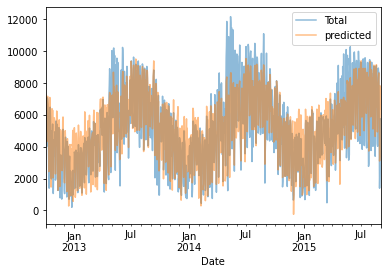

In [ ]:
daily[['Total', 'predicted']].plot(alpha=0.5);

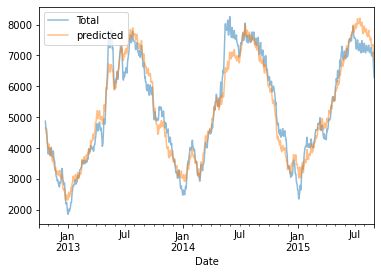

In [ ]:
daily[['Total', 'predicted']].rolling(20).mean().plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [ ]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              570.525552
Tue              780.042590
Wed              718.723149
Thu              527.354664
Fri              -92.240364
Sat            -2691.453015
Sun            -2747.933321
holiday        -2391.002632
daylight_hrs     269.994878
dry day         1460.657977
Temp (C)         126.022610
annual            51.727894
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty.
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [ ]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [ ]:
params.shape

(12,)

With these errors estimated, let's again look at the results:

In [ ]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            571.0  179.0
Tue            780.0  171.0
Wed            719.0  171.0
Thu            527.0  174.0
Fri            -92.0  168.0
Sat          -2691.0  164.0
Sun          -2748.0  171.0
holiday      -2391.0  332.0
daylight_hrs   270.0   19.0
dry day       1461.0   62.0
Temp (C)       126.0    8.0
annual          52.0   37.0


In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(daily['Total'], daily['predicted']))

915120.7557622425
